In [1]:
# import sys
# !{sys.executable} -m pip install sodapy socrata-py python-dotenv

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
import pathlib
import requests
import matplotlib.pyplot as plt

In [3]:
def fetch_nyc_data(dataset_id, total_records=1000, limit=100, where_clause=None):
    """Fetch data from NYC Open Data API using pagination"""
    
    all_data = []
    offset = 0
    
    while len(all_data) < total_records:
        url = f"https://data.cityofnewyork.us/resource/{dataset_id}.json"
        params = {
            '$offset': offset,
            '$limit': limit,
            '$$app_token': os.getenv("SOCRATA_APP_TOKEN")
        }
        
        if where_clause:
            params['$where'] = where_clause
        
        print(f"Fetching records {offset} to {offset + limit}...")
        
        try:
            response = requests.get(url, params=params) #timeout=60
            response.raise_for_status()
            
            data = response.json()
            
            if not data:
                print("No more data available")
                break
                
            all_data.extend(data)
            print(f"Retrieved {len(data)} records (total: {len(all_data)})")
            
            if len(data) < limit:
                print("Reached end of dataset")
                break
                
            offset += limit
                
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            break
    
    return all_data

# Fetch the data with custom where clause
# for some reason "status IN ('Open', In Progress)..." is not working properly
raw_data_open = fetch_nyc_data(
    "erm2-nwe9", 
    #total_records=1000, 
    #limit=100,
    where_clause="status IN ('Open') AND created_date >= '2025-01-01T00:00:00'"
)

raw_data_inProgress = fetch_nyc_data(
    "erm2-nwe9", 
    #total_records=1000, 
    #limit=100,
    where_clause="status IN ('In Progress') AND created_date >= '2025-01-01T00:00:00'"
)

# Combine
combined_data = raw_data_open + raw_data_inProgress

# Create DataFrame from combined data
results_df = pd.DataFrame(combined_data)

# Convert created_date to datetime just in case for proper sorting
results_df['created_date'] = pd.to_datetime(results_df['created_date'])

# Sort by created_date in descending order (most recent first)
results_df = results_df.sort_values('created_date', ascending=False).reset_index(drop=True)

columns_to_keep = [
    'unique_key',
    'created_date',
    'agency',
    'agency_name',
    'complaint_type',
    'descriptor',
    'incident_zip',
    'incident_address',
    'street_name',
    'address_type',
    'city',
    'facility_type',
    'status',
    'resolution_description',
    'resolution_action_updated_date',
    'community_board',
    'council_district',
    'bbl',
    'police_precinct',
    'borough',
    'park_borough',
    'x_coordinate_state_plane',
    'y_coordinate_state_plane',
    'latitude',
    'longitude',
    'location'
]

# Filter to only columns that exist in the dataframe
columns_to_keep = [col for col in columns_to_keep if col in results_df.columns]
results_df = results_df[columns_to_keep]

print(f"\nFinal DataFrame shape: {results_df.shape}")
print(f"\nStatus counts:\n{results_df['status'].value_counts()}")
print(f"\nDate range: {results_df['created_date'].min()} to {results_df['created_date'].max()}")

Fetching records 0 to 100...
Retrieved 100 records (total: 100)
Fetching records 100 to 200...
Retrieved 100 records (total: 200)
Fetching records 200 to 300...
Retrieved 100 records (total: 300)
Fetching records 300 to 400...
Retrieved 100 records (total: 400)
Fetching records 400 to 500...
Retrieved 100 records (total: 500)
Fetching records 500 to 600...
Retrieved 100 records (total: 600)
Fetching records 600 to 700...
Retrieved 100 records (total: 700)
Fetching records 700 to 800...
Retrieved 100 records (total: 800)
Fetching records 800 to 900...
Retrieved 100 records (total: 900)
Fetching records 900 to 1000...
Retrieved 100 records (total: 1000)
Fetching records 0 to 100...
Retrieved 100 records (total: 100)
Fetching records 100 to 200...
Retrieved 100 records (total: 200)
Fetching records 200 to 300...
Retrieved 100 records (total: 300)
Fetching records 300 to 400...
Retrieved 100 records (total: 400)
Fetching records 400 to 500...
Retrieved 100 records (total: 500)
Fetching rec

In [4]:
results_df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,address_type,...,council_district,bbl,police_precinct,borough,park_borough,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,location
0,67682467,2026-01-30 00:37:33,DOHMH,Department of Health and Mental Hygiene,Food Establishment,Food Worker Hygiene,11235,1717 AVENUE Z,AVENUE Z,ADDRESS,...,48,3074380024,Precinct 61,BROOKLYN,BROOKLYN,997526,153580,40.58820782754582,-73.95220089242231,"{'type': 'Point', 'coordinates': [-73.95220089..."
1,67695234,2026-01-29 23:56:20,DOHMH,Department of Health and Mental Hygiene,Non-Residential Heat,Inadequate or No Heat,10010,268 3 AVENUE,3 AVENUE,ADDRESS,...,02,1008770044,Precinct 13,MANHATTAN,MANHATTAN,988712,208084,40.737818024401584,-73.98389887746593,"{'type': 'Point', 'coordinates': [-73.98389887..."
2,67709921,2026-01-29 22:45:17,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,10128,534 EAST 88 STREET,EAST 88 STREET,ADDRESS,...,05,1015840033,Precinct 19,MANHATTAN,MANHATTAN,999440,222288,40.776792452047076,-73.94515481559084,"{'type': 'Point', 'coordinates': [-73.94515481..."
3,67695825,2026-01-29 19:14:33,DOHMH,Department of Health and Mental Hygiene,Smoking or Vaping,Allowed in Smoke Free Area,10454,628 EAST 141 STREET,EAST 141 STREET,ADDRESS,...,08,2025530036,Precinct 40,BRONX,BRONX,1008069,233606,40.80783825306335,-73.91395872877214,"{'type': 'Point', 'coordinates': [-73.91395872..."
4,67695238,2026-01-29 18:36:13,DOHMH,Department of Health and Mental Hygiene,Non-Residential Heat,Inadequate or No Heat,10019,152 WEST 49 STREET,WEST 49 STREET,ADDRESS,...,04,1010010059,Precinct 18,MANHATTAN,MANHATTAN,989133,216123,40.75988283163388,-73.9823738623499,"{'type': 'Point', 'coordinates': [-73.98237386..."


In [5]:
results_df.tail()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,address_type,...,council_district,bbl,police_precinct,borough,park_borough,x_coordinate_state_plane,y_coordinate_state_plane,latitude,longitude,location
1995,64593560,2025-04-08 22:40:23,TLC,Taxi and Limousine Commission,For Hire Vehicle Complaint,Driver Complaint - Non Passenger,11215,392 3 AVENUE,3 AVENUE,ADDRESS,...,39,3009790005,Precinct 78,BROOKLYN,BROOKLYN,987251,184716,40.67367899270782,-73.98918130879443,"{'type': 'Point', 'coordinates': [-73.98918130..."
1996,64176137,2025-02-24 20:41:46,TLC,Taxi and Limousine Commission,Taxi Report,Driver Report - Passenger,10022,5 AVENUE,5 AVENUE,INTERSECTION,...,04,NaN,Precinct 19,MANHATTAN,MANHATTAN,991853,217951,40.76489830047662,-73.97255342667354,"{'type': 'Point', 'coordinates': [-73.97255342..."
1997,63938237,2025-01-30 17:33:02,TLC,Taxi and Limousine Commission,Taxi Report,Driver Report - Passenger,11369,LA GUARDIA AIRPORT,LA GUARDIA AIRPORT,UNRECOGNIZED,...,21,4009260001,Precinct 115,QUEENS,QUEENS,1018236,221443,40.77442086598845,-73.87729410513894,"{'type': 'Point', 'coordinates': [-73.87729410..."
1998,63818691,2025-01-20 19:05:52,TLC,Taxi and Limousine Commission,Taxi Report,Driver Report - Passenger,10036,1535 BROADWAY,BROADWAY,ADDRESS,...,03,1010177501,Precinct 18,MANHATTAN,MANHATTAN,988276,215534,40.75826660917717,-73.98546772308859,"{'type': 'Point', 'coordinates': [-73.98546772..."
1999,63757719,2025-01-13 13:35:42,TLC,Taxi and Limousine Commission,Taxi Report,Driver Report - Passenger,10013,BROOME STREET,BROOME STREET,INTERSECTION,...,01,NaN,Precinct 1,MANHATTAN,MANHATTAN,983424,202797,40.7233075908167,-74.00297997118642,"{'type': 'Point', 'coordinates': [-74.00297997..."


In [6]:
#results_df[:1000].status

In [7]:
# open_records = results_df[results_df['status'] == 'Open']
# print(open_records)

In [8]:
# Create a summary DataFrame
complaint_summary = pd.DataFrame({
    'Complaint Type': results_df['complaint_type'].value_counts().head(10).index,
    'Count': results_df['complaint_type'].value_counts().head(10).values,
    'Percentage': (results_df['complaint_type'].value_counts(normalize=True).head(10).values * 100).round(2)
})

print("\nTop 10 Most Common Complaint Types:")
print(complaint_summary)


Top 10 Most Common Complaint Types:
               Complaint Type  Count  Percentage
0                    Graffiti    155        7.75
1          Food Establishment    142        7.10
2  For Hire Vehicle Complaint    141        7.05
3        UNSANITARY CONDITION     96        4.80
4                Damaged Tree     93        4.65
5              Taxi Complaint     92        4.60
6                    Elevator     88        4.40
7                Building/Use     87        4.35
8           Smoking or Vaping     81        4.05
9          Noise - Helicopter     78        3.90


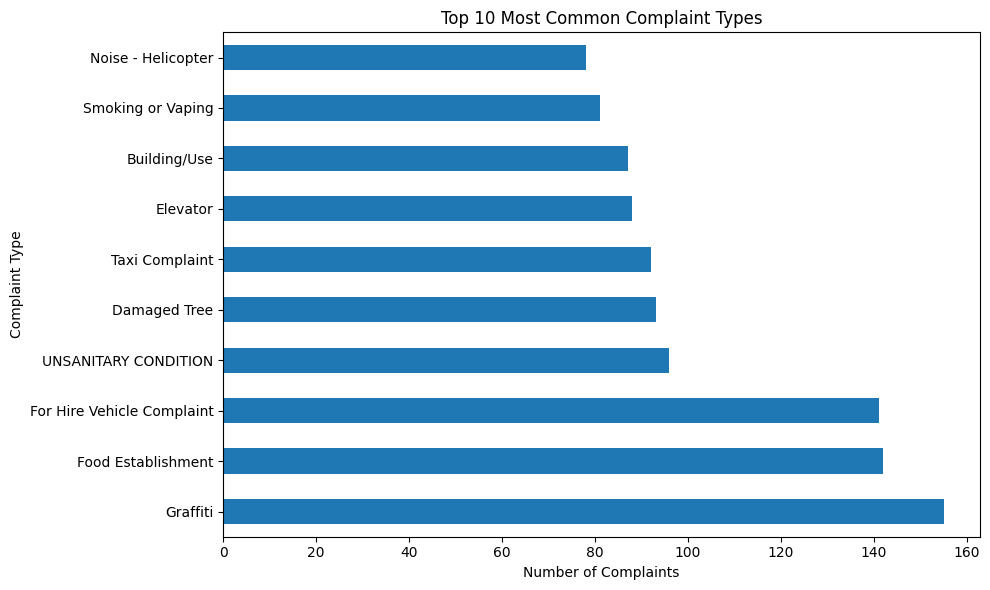

In [9]:
# Plot top 10
results_df['complaint_type'].value_counts().head(10).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.title('Top 10 Most Common Complaint Types')
plt.tight_layout()
plt.show()